In [1]:
import tensorflow as tf
import numpy as np
import pathlib


In [2]:
data_root = pathlib.Path('../input/train_data/')


In [3]:
data_root

PosixPath('../input/train_data')

In [4]:
all_image_paths = list(data_root.glob('./*'))
all_image_paths = [str(path) for path in all_image_paths]


In [5]:
all_image_paths[:10]

['../input/train_data/cast_ok_0_296.jpeg',
 '../input/train_data/cast_def_0_135.jpeg',
 '../input/train_data/cast_def_0_21.jpeg',
 '../input/train_data/cast_def_0_9.jpeg',
 '../input/train_data/cast_def_0_175.jpeg',
 '../input/train_data/cast_def_0_211.jpeg',
 '../input/train_data/cast_def_0_61.jpeg',
 '../input/train_data/cast_def_0_207.jpeg',
 '../input/train_data/cast_def_0_355.jpeg',
 '../input/train_data/cast_def_0_50.jpeg']

In [6]:
import os
import IPython.display as display
import random


def caption_image(image_path):
    if 'ok' in image_path:
        return "OK"
    else:
        return "DEF"


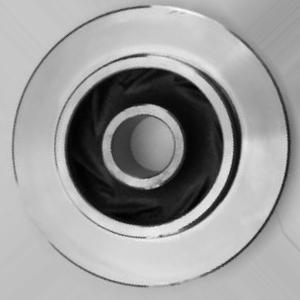

OK


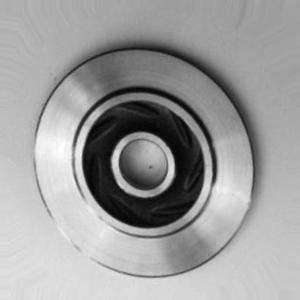

OK


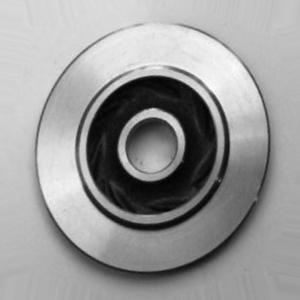

OK


In [7]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print(caption_image(image_path))


In [8]:
label_names = ['ok', 'def']

label_to_index = dict((name, index) for index, name in enumerate(label_names))


In [9]:
label_to_index

{'ok': 0, 'def': 1}

In [10]:
def mk_idx(x):
    if 'ok' in x:
        return 'ok'
    else:
        return 'def'


In [11]:
all_image_labels = [label_to_index[mk_idx(path)] for path in all_image_paths]

In [12]:
for path in all_image_paths[:10]:
    print(mk_idx(path))

ok
def
def
def
def
def
def
def
def
def


In [13]:
all_image_labels[:10]

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [14]:
img_path =all_image_paths[0]
img_path

'../input/train_data/cast_ok_0_296.jpeg'

In [15]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00...


In [16]:
img_tensor = tf.image.decode_image(img_raw)


In [17]:
print(img_tensor.shape)
print(img_tensor.dtype)

(300, 300, 3)
<dtype: 'uint8'>


In [18]:
img_final = tf.image.resize(img_tensor, [192,192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())


(192, 192, 3)
0.009903492
0.9928424


In [19]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192,192])
    image /= 255.0

    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)


In [20]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'OK')

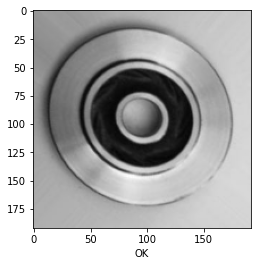

In [21]:
image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.xlabel(caption_image(image_path))


In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE


In [23]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)


In [24]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)


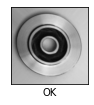

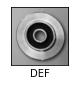

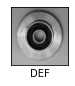

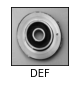

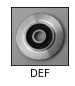

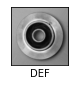

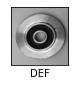

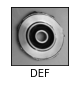

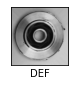

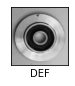

In [25]:
plt.figure(figsize=(8,8))

for n, image in enumerate(image_ds.take(10)):
    plt.subplot(2,5,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(caption_image(all_image_paths[n]))
    plt.show()


In [26]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))


In [27]:
for label in label_ds.take(10):
    print(label_names[label.numpy()])


ok
def
def
def
def
def
def
def
def
def


In [28]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))


In [29]:
image_label_ds

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>

In [30]:
BATCH_SIZE = 32
image_count = len(all_image_paths)

ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)

ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>

In [31]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192,192,3), include_top=False)
mobile_net.trainable = False


In [32]:
def change_range(image, label):
    return 2*image -1, label

keras_ds = ds.map(change_range)


In [33]:
image_batch, label_batch = next(iter(keras_ds))


In [34]:
feature_map_batch = mobile_net(image_batch)


In [35]:
feature_map_batch = mobile_net(image_batch)

model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1)
])


In [36]:
logit_batch = model(image_batch).numpy()


In [37]:
logit_batch.min()

-0.48733678

In [38]:
logit_batch.max()

1.1693261

In [39]:
logit_batch.shape

(32, 1)

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',
                metrics=['accuracy'])


In [41]:
len(model.trainable_variables)

2

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [43]:
steps_per_epoch = tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

8.0

In [44]:
model.fit(ds, epochs=30, steps_per_epoch=30)

Epoch 1/30
30/30 [==============================] - 2s 72ms/step - loss: 1.2464 - accuracy: 0.6469
Epoch 2/30
30/30 [==============================] - 2s 71ms/step - loss: 4.2087 - accuracy: 0.6594
Epoch 3/30
30/30 [==============================] - 2s 71ms/step - loss: 6.2427 - accuracy: 0.5906
Epoch 4/30
30/30 [==============================] - 2s 72ms/step - loss: 6.0679 - accuracy: 0.6021
Epoch 5/30
30/30 [==============================] - 2s 72ms/step - loss: 6.0362 - accuracy: 0.6042
Epoch 6/30
30/30 [==============================] - 2s 72ms/step - loss: 6.1473 - accuracy: 0.5969
Epoch 7/30
30/30 [==============================] - 2s 73ms/step - loss: 6.1156 - accuracy: 0.5990
Epoch 8/30
30/30 [==============================] - 2s 73ms/step - loss: 6.0679 - accuracy: 0.6021
Epoch 9/30
30/30 [==============================] - 2s 73ms/step - loss: 6.0362 - accuracy: 0.6042
Epoch 10/30
30/30 [==============================] - 2s 72ms/step - loss: 6.2744 - accuracy: 0.5885
Epoch 11/